## **INTERNSHIP REPORT**

### **Part 1** : Context / Autocall / Tasks
### **Part 2** : Contributions
### **Part 3** : NLP for Rates Dynamics

### **Part 1** : Autocall

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import ticker

def autocall_payout(pdi_barrier=0.5, 
                    coupon_amount = 0.1,
                    coupon_barrier = 0.75,
                    plot_payoff = False):
    """ Return the payoff of a classic autocall
    """
    # define the componant
    udl = np.arange(0,2,0.001)
    put = np.arange(1,0,-0.001)
    put = np.resize(put,udl.shape)

    # Put Down and In to be sold by the buyer of the autocall
    pdi = put * (udl<=pdi_barrier)
    # The coupon to be received by the buyer of the autocall, 
    # if udl is above the barrier
    coupon = coupon_amount * (udl>=coupon_barrier)

    # buying an autocall consist of selling the PDI to get coupons 
    autocall = - pdi + coupon
    
    if plot_payoff:
        y = autocall_payout()
        x = np.arange(0, 200, 200 / y.size)

        # Convert the y-axis values to percentages
        y_percent = y * 100
        
        plt.figure(figsize=(10,5))
        plt.plot(x, y_percent)
        plt.grid(True)  # Add a grid background

        y_ticks = [-100,-75,-50,-25,0,coupon_amount*100]
        plt.yticks(y_ticks)
        
        plt.title("Classic Autocall Payoff")
        plt.xlabel("Spot (%)")
        plt.ylabel("Premium (%)")  
        plt.show()

    return autocall

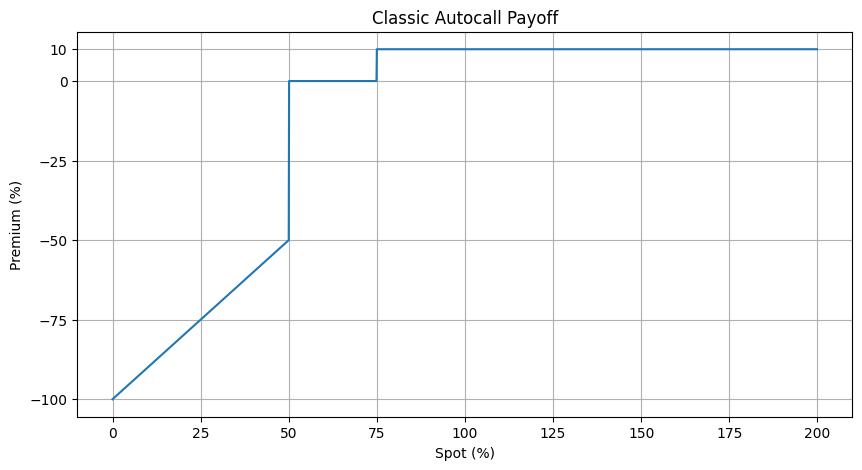

In [2]:
_ = autocall_payout(plot_payoff=True)

### **Part 3** : NLP for Rates Dynamics

**Rates : Data manipulation**

In [238]:
import pandas as pd

In [281]:
# Get all the files containing rates minus fed funds "FF.csv"
file_rates = ["RIFSPFFNB.csv","T3MFF.csv","T6MFF.csv",
           "T1YFF.csv","T5YFF.csv","T10YFF.csv","T10Y2Y.csv"]
names_rates = [file.replace(".csv","") for file in file_rates]

# Store all the rates in one dataframe
concat_rates = pd.DataFrame()

for file in file_rates:
    # Read each CSV file into a temporary DataFrame
    temp_df = pd.read_csv(file)
    # Set the date column as the index
    temp_df.set_index('DATE', inplace=True)
    # Concatenate with the result dataframe
    concat_rates = pd.concat([concat_rates, temp_df], axis=1, join='outer', sort=True)

# Sort the dataframe by date
concat_rates.sort_index(inplace=True)

# Filter rows based on the date condition
concat_rates = concat_rates[concat_rates.index >= '1990-01-04']

concat_rates = concat_rates.replace(".",np.nan).astype(float)
# Forward fill missing values
concat_rates = concat_rates.fillna(method='ffill')

# Display the resulting DataFrame
print(concat_rates)

            RIFSPFFNB  T3MFF  T6MFF  T1YFF  T5YFF  T10YFF  T10Y2Y
DATE                                                             
1990-01-04       8.29  -0.45  -0.39  -0.47  -0.38   -0.31    0.06
1990-01-05       8.20  -0.41  -0.35  -0.41  -0.28   -0.21    0.09
1990-01-08       8.27  -0.48  -0.39  -0.46  -0.35   -0.25    0.12
1990-01-09       8.25  -0.45  -0.43  -0.47  -0.33   -0.23    0.11
1990-01-10       8.12  -0.37  -0.34  -0.35  -0.20   -0.09    0.12
...               ...    ...    ...    ...    ...     ...     ...
2023-11-03       5.33   0.20   0.12  -0.04  -0.84   -0.76   -0.26
2023-11-06       5.33   0.23   0.14   0.00  -0.73   -0.66   -0.26
2023-11-07       5.33   0.22   0.14   0.00  -0.80   -0.75   -0.33
2023-11-08       5.33   0.21   0.13   0.01  -0.82   -0.84   -0.44
2023-11-09       5.33   0.21   0.13   0.01  -0.82   -0.84   -0.41

[8831 rows x 7 columns]


Here we have the fed funds, the series of rates minus fed funds, and the serie 10y-2y 

We add back the fed funds to retrieve the true rates series. 
We extract the 2Y yields from the last serie

Finally, we rename the columns to get lisible names

In [282]:
# Add Fed Funds rate
rates_clear = concat_rates[names_rates[1:-1]].add(concat_rates[names_rates[0]], axis=0)
# Rename the columns 
rates_clear.columns = ["3M","6M","1Y","5Y","10Y"]

# Now that we have the 10y yields, get the 2 years yields
rates_2Y = - concat_rates[names_rates[-1]].sub(rates_clear["10Y"], axis=0)

# Concatenate all the rates and put in order
rates = pd.concat([rates_clear, rates_2Y], axis=1, join='outer', sort=True)
rates.columns = ["3M","6M","1Y","5Y","10Y","2Y"]
rates = rates[["3M","6M","1Y","2Y","5Y","10Y"]]

Computing inversion dataframe : 
3m - 2y : Short term inversion
3m - 10y : Full inversion
2y - 10y :  Mid to Long term inversion


In [283]:
rates_inversions = pd.concat([rates["3M"]-rates["2Y"], 
                              rates["3M"]-rates["10Y"],
                              rates["2Y"]-rates["10Y"],
                              ], axis=1, join='outer', sort=True)
rates_inversions.columns = ["3M_2Y","3M_10Y","2Y_10Y"]

In [284]:
rates_inversions.to_parquet("rates_inversions.parquet")

**Rates : Data exploration**

In [285]:
rates

,3M,6M,1Y,2Y,5Y,10Y
DATE,,,,,,
1990-01-04,7.84,7.90,7.82,7.92,7.91,7.98
1990-01-05,7.79,7.85,7.79,7.90,7.92,7.99
1990-01-08,7.79,7.88,7.81,7.90,7.92,8.02
1990-01-09,7.80,7.82,7.78,7.91,7.92,8.02
1990-01-10,7.75,7.78,7.77,7.91,7.92,8.03
...,...,...,...,...,...,...
2023-11-03,5.53,5.45,5.29,4.83,4.49,4.57
2023-11-06,5.56,5.47,5.33,4.93,4.60,4.67
2023-11-07,5.55,5.47,5.33,4.91,4.53,4.58


In [7]:
rates_inversions

,3M_2Y,3M_10Y,2Y_10Y
DATE,,,
2000-01-04,-0.87,-1.06,-0.19
2000-01-05,-0.94,-1.18,-0.24
2000-01-06,-0.94,-1.16,-0.22
2000-01-07,-0.93,-1.14,-0.21
2000-01-10,-0.96,-1.15,-0.19
...,...,...,...
2023-11-03,0.70,0.96,0.26
2023-11-06,0.63,0.89,0.26
2023-11-07,0.64,0.97,0.33


<AxesSubplot: xlabel='DATE'>

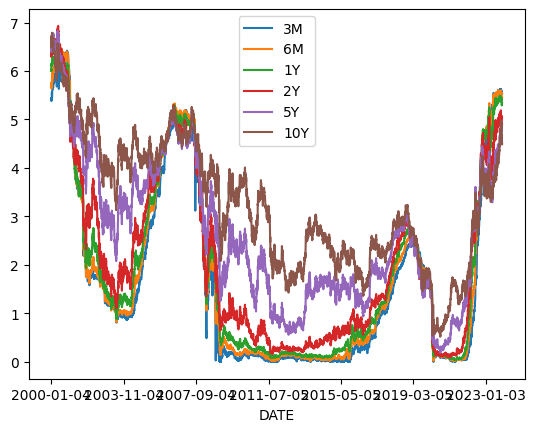

In [8]:
rates.plot()

<AxesSubplot: xlabel='DATE'>

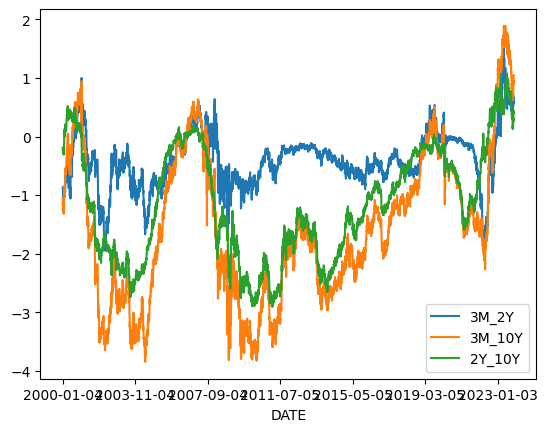

In [9]:
rates_inversions.plot()

Plotting the yield curves trough time in 3D

In [10]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
fig = go.Figure(data=[
    go.Surface(z=rates.values, x=rates.columns, y=rates.index, colorscale='portland', showscale=False,
               contours=dict(
                   x=dict(show=True, color='black')
               ),
               colorbar=dict(title='Rate', tickformat='.2%'))
])

fig.update_layout(
    title='Yield curves since 2000',
    autosize=False,
    width=1000, height=700,
    margin=dict(l=65, r=50, b=65, t=25),
    scene = dict(
        xaxis = dict(autorange='reversed', title='Maturity'),
        yaxis = dict(
            title = 'Years',
            tickmode = 'linear',
            dtick = 'M24'
        ),
        zaxis = dict(title='Rate'),
        aspectmode='manual',
        aspectratio=dict(x=1, y=2, z=0.75),
    )
)
fig.show()

**Textual data : data manipulation**

The basic data sets are composed of 8 columns in each : 
- *title*
- *speaker*
- *event*
- *year*
- *text*
- *date*
- *text_len*
- *location*

In [95]:
FED_data = pd.read_csv("./KaggleData/fed_speeches_1996_2020.csv",index_col=0)

In [96]:
FED_data.columns

Index(['title', 'speaker', 'event', 'year', 'text', 'date', 'text_len',
       'location'],
      dtype='object')

In [97]:
FED_data = FED_data.dropna()
print(f" There are on average {int(np.mean([len(line.split()) for line in FED_data.text]))} words per text")

 There are on average 3232 words per text


In [98]:
FED_data.head()

,title,speaker,event,year,text,date,text_len,location
link,,,,,,,,
https://www.federalreserve.gov/boarddocs/speeches/1996/19961219.htm,Supervision of bank risk-taking,Vice Chair Alice M. Rivlin,At the The Brookings Institution National Issu...,1996.0,I discovered when I joined the Board of Govern...,19961219.0,3671,D.C.
https://www.federalreserve.gov/boarddocs/speeches/1996/19961206.htm,Social security,Chairman Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,1996.0,I am privileged to accept the Union League of...,19961206.0,2596,Pennsylvania
https://www.federalreserve.gov/boarddocs/speeches/1996/19961205.htm,The challenge of central banking in a democrat...,Chairman Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,1996.0,The Challenge of Central Banking in a Democrat...,19961205.0,4344,D.C.
https://www.federalreserve.gov/boarddocs/speeches/1996/19961203.htm,Clearinghouses and risk management,"Governor Edward W. Kelley, Jr.","At the 1996 Payments System Risk Conference, W...",1996.0,It is a pleasure to be with you this morning ...,19961203.0,2527,D.C.
https://www.federalreserve.gov/boarddocs/speeches/1996/19961125.htm,Supervisory and regulatory responses to financ...,Governor Susan M. Phillips,At the BAI Seminar on Regulatory Policy Change...,1996.0,Supervisory and Regulatory Responses to Financ...,19961125.0,2222,D.C.


Reformate the dates

In [99]:
from datetime import datetime
# Convert to datetime object
dates_array = [datetime.strptime(str(int(float_date)), '%Y%m%d').strftime('%Y-%m-%d') for float_date in FED_data.date]
FED_data["new_date"]  = dates_array


In [100]:
FED_data = FED_data[["speaker", "text", "new_date"]]
FED_data.columns = ["speaker", "text", "date"]

In [101]:
print(len(FED_data)-len(FED_data.date.unique()))

217


More than one text per date, so we keep this structure for now, we will average the sentiment per date after the analysis

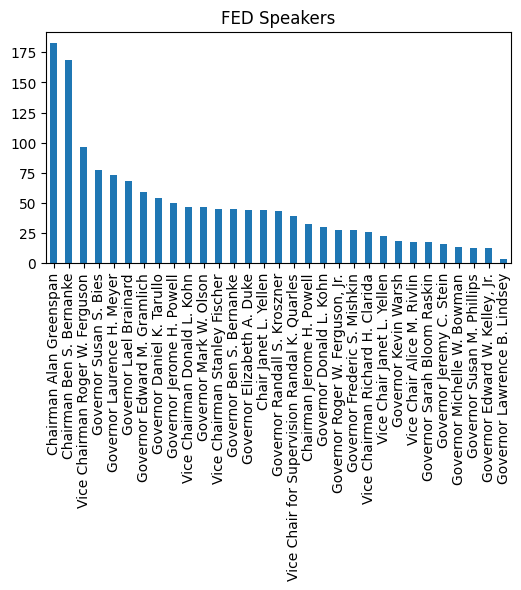

 There are 31 speakers for the FED, and 1453 texts


In [102]:
fig, ax1 = plt.subplots(1, 1, sharey=True,figsize=(6, 3))
FED_data["speaker"].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("FED Speakers")
plt.show()

FED_speakers = FED_data["speaker"].unique()
print(f" There are {len(FED_speakers)} speakers for the FED, and {len(FED_data)} texts")

**Preprocessing**

In [103]:
import pandas as pd
import numpy as np
import re

from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns 

from langdetect import detect

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [104]:
def translate_text(text:str="",title:str=""):
    """
    Translate the text in the data frame 
    """
    try:
        original_lang = detect(text)
        if original_lang != "en":
            
            text_blob = TextBlob(text)
            title_blob = TextBlob(title)
            translated_text = str(text_blob.translate(from_lang=original_lang, to='en'))
            translated_title = str(title_blob.translate(from_lang=original_lang, to='en'))
            
            return original_lang,translated_text,translated_title
        else:
            return "en",text,title
    except:
        return "en","",""

# Using the stop words of nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove("not")

def clean_text(text):
    text = re.sub(r'[^\w\s]|â', ' ', text.lower())
    removed_stop_words = []
    removed_stop_words.append(
        ' '.join([word for word in text.split(' ') 
                    if word not in stopwords]))
    return removed_stop_words[0]

def translate_and_clean(df):
    """
    Applies the translate function and sentiment analysis to a df
    """
    df[["original_lang","text","title"]]=[translate_text(*x) for x in tuple(zip(df["text"],df["title"]))]
    
    df["text"] = df["text"].apply(lambda x : clean_text(x))
    df["title"] = df["title"].apply(lambda x : clean_text(x))
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mvero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
clean_text("This is not . a crisis")

'not   crisis'

**Sentiment Analysis with FinBERT**

In [106]:
from deep_translator import GoogleTranslator
from sklearn.preprocessing import OneHotEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

In [108]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

finBERT = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

def translate_text(text:str=""):
    """
    Translate the text in the data frame 
    """
    try:
        original_lang = detect(text)
        if original_lang != "en":
            translated_text = GoogleTranslator(source=original_lang, target='en').translate(text)
            return original_lang,translated_text
        else:
            return "en",text
    except:
        return "en",""
    
def finBERT_get_sentiment(model, text:str=""):
    """
    From https://www.imperial.ac.uk/media/imperial-college/faculty-of-natural-sciences/department-of-mathematics/math-finance/Xia_Ruizhe_01201752.pdf
    Original Git : https://github.com/ProsusAI/finBERT => https://huggingface.co/yiyanghkust/finbert-tone
    Up to date git : https://github.com/yya518/FinBERT => https://huggingface.co/ProsusAI/finbert
    """

    # Split the text into sentences
    text_lines = text.split(".")

    # Get rid of stop words and other unuseful char
    text_clean_lines = [clean_text(line) for line in text_lines]
    
    # Get the sentiment classification from the model 
    sentiments = model(text_clean_lines)

    # Add the length (nb of words) for each sentence
    for i, dic in enumerate(sentiments):
        sentiments[i]["length"] = len(text_clean_lines[i].split(" ")) 

    # Convert to df 
    sentiments_df = pd.DataFrame(sentiments).groupby("label") \
                     .agg({"label":'count',
                           'score':'mean',
                           'length':'mean'}) \
                     .rename(columns={"label":'label_count',
                                      'score':'score_mean',
                                      'length':'length_mean'})
    
    # Compute weighted average sentiment by length
    neg_score, neu_score, pos_score = 0.0, 0.0, 0.0
    if "Negative" in sentiments_df.index:
        neg_score = sentiments_df.loc["Negative","score_mean"] * sentiments_df.loc["Negative","label_count"] / sentiments_df.label_count.sum()
    if "Neutral" in sentiments_df.index:
        neu_score = sentiments_df.loc["Neutral","score_mean"] * sentiments_df.loc["Neutral","label_count"] / sentiments_df.label_count.sum()
    if "Positive" in sentiments_df.index:
        pos_score = sentiments_df.loc["Positive","score_mean"] * sentiments_df.loc["Positive","label_count"] / sentiments_df.label_count.sum()

    # Get different relative scores
    agg_score = neg_score + neu_score + pos_score

    positivness_score = pos_score / agg_score
    negativness_score = neg_score / agg_score
    neutrality_score = neu_score / agg_score
    spread_score = pos_score - neg_score

    # Send all the results as dictionnary
    result = {
        "neg_score":neg_score,
        "neu_score":neu_score,
        "pos_score":pos_score,
        "agg_score":agg_score,
        "positivness_score":positivness_score,
        "negativness_score":negativness_score,
        "neutrality_score":neutrality_score,
        "spread_score":spread_score,
    }
    return result


def finBERT_get_sentiments(model, text_serie):
    all_sentiments = []
    for count, text in enumerate(text_serie, start=1):
        all_sentiments.append(list(finBERT_get_sentiment(model, text).values()))
        if count%10 == 0:
            print(f"{text_serie.name} : {count} done, remaining {len(text_serie) - count}")
    return np.asarray(all_sentiments)


def one_hot_speaker(df):
    """
    Tranform the speakers into one hot encoding columns
    """ 
    OHE = OneHotEncoder(sparse_output=False)
    speakers_ohe = OHE.fit_transform(df[["speaker"]])    
    colnames = [f"speaker_{i+1}" for i in range(speakers_ohe.shape[1])]
    df[colnames] = speakers_ohe.astype(int)

    return df

def translate_and_analyse_df_with_finBERT(df):
    """
    Applies the translate function and sentiment analysis to a df
    """
    # Translate if needed the texts and titles
    df[["original_lang","text"]]=[translate_text(*x) for x in tuple(zip(df["text"]))]
    
    output_names = ["neg_score", "neu_score", "pos_score", "agg_score", "positivness_score", "negativness_score", "neutrality_score", "spread_score"]

    # Get sentiment on the text
    df[output_names] = finBERT_get_sentiments(finBERT, df["text"])
    
    return df

In [109]:
FED_data.columns

Index(['speaker', 'text', 'date'], dtype='object')

In [110]:
FED_data_finBERT = translate_and_analyse_df_with_finBERT(FED_data)

text : 10 done, remaining 1443
text : 20 done, remaining 1433
text : 30 done, remaining 1423
text : 40 done, remaining 1413
text : 50 done, remaining 1403
text : 60 done, remaining 1393
text : 70 done, remaining 1383
text : 80 done, remaining 1373
text : 90 done, remaining 1363
text : 100 done, remaining 1353
text : 110 done, remaining 1343
text : 120 done, remaining 1333
text : 130 done, remaining 1323
text : 140 done, remaining 1313
text : 150 done, remaining 1303
text : 160 done, remaining 1293
text : 170 done, remaining 1283
text : 180 done, remaining 1273
text : 190 done, remaining 1263
text : 200 done, remaining 1253
text : 210 done, remaining 1243
text : 220 done, remaining 1233
text : 230 done, remaining 1223
text : 240 done, remaining 1213
text : 250 done, remaining 1203
text : 260 done, remaining 1193
text : 270 done, remaining 1183
text : 280 done, remaining 1173
text : 290 done, remaining 1163
text : 300 done, remaining 1153
text : 310 done, remaining 1143
text : 320 done, 

Computing the average values for the different score if more than one per day

In [111]:
try:
    FED_data_finBERT = pd.read_parquet("FED_data_finBERT_20231112_2145.parquet")
except:
    FED_data_finBERT.to_parquet("FED_data_finBERT_20231112_2145.parquet")

In [112]:
FED_data_finBERT_full = one_hot_speaker(FED_data_finBERT)

In [115]:
FED_data_finBERT_full.columns

Index(['speaker', 'text', 'date', 'original_lang', 'neg_score', 'neu_score',
       'pos_score', 'agg_score', 'positivness_score', 'negativness_score',
       'neutrality_score', 'spread_score', 'speaker_1', 'speaker_2',
       'speaker_3', 'speaker_4', 'speaker_5', 'speaker_6', 'speaker_7',
       'speaker_8', 'speaker_9', 'speaker_10', 'speaker_11', 'speaker_12',
       'speaker_13', 'speaker_14', 'speaker_15', 'speaker_16', 'speaker_17',
       'speaker_18', 'speaker_19', 'speaker_20', 'speaker_21', 'speaker_22',
       'speaker_23', 'speaker_24', 'speaker_25', 'speaker_26', 'speaker_27',
       'speaker_28', 'speaker_29', 'speaker_30', 'speaker_31'],
      dtype='object')

In [116]:
FED_data_finBERT_full = FED_data_finBERT_full[['date', 'original_lang', 'neg_score', 'neu_score',
       'pos_score', 'agg_score', 'positivness_score', 'negativness_score',
       'neutrality_score', 'spread_score', 'speaker_1', 'speaker_2',
       'speaker_3', 'speaker_4', 'speaker_5', 'speaker_6', 'speaker_7',
       'speaker_8', 'speaker_9', 'speaker_10', 'speaker_11', 'speaker_12',
       'speaker_13', 'speaker_14', 'speaker_15', 'speaker_16', 'speaker_17',
       'speaker_18', 'speaker_19', 'speaker_20', 'speaker_21', 'speaker_22',
       'speaker_23', 'speaker_24', 'speaker_25', 'speaker_26', 'speaker_27',
       'speaker_28', 'speaker_29', 'speaker_30', 'speaker_31']]

In [118]:
FED_data_finBERT_grouped = FED_data_finBERT_full.groupby('date').agg({
    'neg_score': 'mean', 
    'neu_score': 'mean',
    'pos_score': 'mean', 
    'agg_score': 'mean', 
    'positivness_score': 'mean', 
    'negativness_score': 'mean',
    'neutrality_score': 'mean', 
    'spread_score': 'mean',
    'speaker_1':'max', 
    'speaker_2':'max', 
    'speaker_3':'max', 
    'speaker_4':'max', 
    'speaker_5':'max', 
    'speaker_6':'max', 
    'speaker_7':'max', 
    'speaker_8':'max', 
    'speaker_9':'max', 
    'speaker_10':'max', 
    'speaker_11':'max', 
    'speaker_12':'max', 
    'speaker_13':'max', 
    'speaker_14':'max', 
    'speaker_15':'max', 
    'speaker_16':'max', 
    'speaker_17':'max', 
    'speaker_18':'max', 
    'speaker_19':'max', 
    'speaker_20':'max', 
    'speaker_21':'max', 
    'speaker_22':'max', 
    'speaker_23':'max', 
    'speaker_24':'max', 
    'speaker_25':'max', 
    'speaker_26':'max', 
    'speaker_27':'max', 
    'speaker_28':'max', 
    'speaker_29':'max', 
    'speaker_30':'max', 
    'speaker_31':'max'
}).reset_index()

In [123]:
FED_data_finBERT_grouped.set_index('date', inplace=True)
FED_data_finBERT_grouped.sort_index(inplace=True)

In [124]:

FED_data_finBERT_grouped.to_parquet("FED_data_finBERT_sorted.parquet")

<AxesSubplot: xlabel='date'>

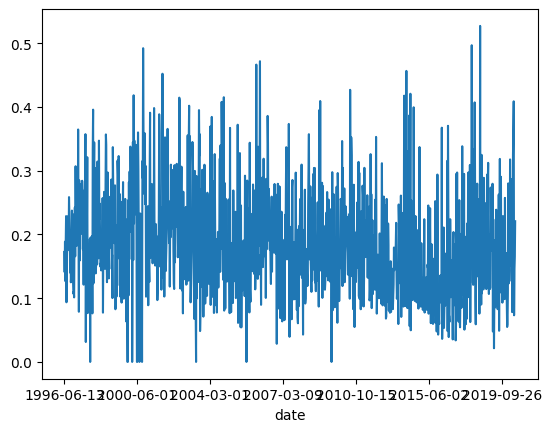

In [127]:
FED_data_finBERT_grouped.pos_score.plot()

**Sentiment Analysis with FOMC-RoBERTa**

In [129]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)
model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")

roberta = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, framework="pt")

In [130]:
def roberta_get_sentiment(model, text:str=""):
    """
    From https://aclanthology.org/2023.acl-long.368.pdf
    Original Git : https://github.com/gtfintechlab/fomc-hawkish-dovish/tree/main => https://huggingface.co/gtfintechlab/FOMC-RoBERTa
    """

    # Split the text into sentences
    text_lines = text.split(".")

    # Get rid of stop words and other unuseful char
    text_clean_lines = [clean_text(line) for line in text_lines]
    
    # Get the sentiment classification from the model 
    sentiments = model(text_clean_lines)

    # Add the length (nb of words) for each sentence
    for i, dic in enumerate(sentiments):
        sentiments[i]["length"] = len(text_clean_lines[i].split(" ")) 

    # Convert to df and modify the label names to match the output of BERT (homogeneity)
    sentiments = pd.DataFrame(sentiments)
    sentiments = sentiments.replace({'label': {'LABEL_1': 'Negative', 'LABEL_0': 'Positive', 'LABEL_2':'Neutral'}})

    sentiments_df = pd.DataFrame(sentiments).groupby("label") \
                     .agg({"label":'count',
                           'score':'mean',
                           'length':'mean'}) \
                     .rename(columns={"label":'label_count',
                                      'score':'score_mean',
                                      'length':'length_mean'})
    
    # Compute weighted average sentiment by length
    neg_score, neu_score, pos_score = 0.0, 0.0, 0.0
    if "Negative" in sentiments_df.index:
        neg_score = sentiments_df.loc["Negative","score_mean"] * sentiments_df.loc["Negative","label_count"] / sentiments_df.label_count.sum()
    if "Neutral" in sentiments_df.index:
        neu_score = sentiments_df.loc["Neutral","score_mean"] * sentiments_df.loc["Neutral","label_count"] / sentiments_df.label_count.sum()
    if "Positive" in sentiments_df.index:
        pos_score = sentiments_df.loc["Positive","score_mean"] * sentiments_df.loc["Positive","label_count"] / sentiments_df.label_count.sum()

    # Get different relative scores
    agg_score = neg_score + neu_score + pos_score

    positivness_score = pos_score / agg_score
    negativness_score = neg_score / agg_score
    neutrality_score = neu_score / agg_score
    spread_score = pos_score - neg_score

    # Send all the results as dictionnary
    result = {
        "neg_score":neg_score,
        "neu_score":neu_score,
        "pos_score":pos_score,
        "agg_score":agg_score,
        "positivness_score":positivness_score,
        "negativness_score":negativness_score,
        "neutrality_score":neutrality_score,
        "spread_score":spread_score,
    }
    return result


def roberta_get_sentiments(model, text_serie):
    all_sentiments = []
    for count, text in enumerate(text_serie, start=1):
        all_sentiments.append(list(roberta_get_sentiment(model, text).values()))
        if count%10 == 0:
            print(f"{text_serie.name} : {count} done, remaining {len(text_serie) - count}")
    return np.asarray(all_sentiments)


def translate_and_analyse_df_with_roberta(df):
    """
    Applies the translate function and sentiment analysis to a df
    """
    # Translate if needed the texts and titles
    df[["original_lang","text"]]=[translate_text(*x) for x in tuple(zip(df["text"]))]
    
    output_names = ["neg_score", "neu_score", "pos_score", "agg_score", "positivness_score", "negativness_score", "neutrality_score", "spread_score"]

    # Get sentiment on the text
    df[output_names] = roberta_get_sentiments(roberta, df["text"])
    
    return df

In [132]:
FED_data = pd.read_csv("./KaggleData/fed_speeches_1996_2020.csv",index_col=0)
FED_data = FED_data.dropna()
dates_array = [datetime.strptime(str(int(float_date)), '%Y%m%d').strftime('%Y-%m-%d') for float_date in FED_data.date]
FED_data["new_date"]  = dates_array
FED_data = FED_data[["speaker", "text", "new_date"]]
FED_data.columns = ["speaker", "text", "date"]

In [138]:
try:
    FED_data_roberta = pd.read_csv("FED_data_roberta.csv")
except:
    FED_data_roberta = translate_and_analyse_df_with_roberta(FED_data)

In [139]:
FED_data_roberta_full = one_hot_speaker(FED_data_roberta)
FED_data_roberta_full = FED_data_roberta_full[['date', 'neg_score', 'neu_score',
       'pos_score', 'agg_score', 'positivness_score', 'negativness_score',
       'neutrality_score', 'spread_score', 'speaker_1', 'speaker_2',
       'speaker_3', 'speaker_4', 'speaker_5', 'speaker_6', 'speaker_7',
       'speaker_8', 'speaker_9', 'speaker_10', 'speaker_11', 'speaker_12',
       'speaker_13', 'speaker_14', 'speaker_15', 'speaker_16', 'speaker_17',
       'speaker_18', 'speaker_19', 'speaker_20', 'speaker_21', 'speaker_22',
       'speaker_23', 'speaker_24', 'speaker_25', 'speaker_26', 'speaker_27',
       'speaker_28', 'speaker_29', 'speaker_30', 'speaker_31']]
FED_data_roberta_grouped = FED_data_roberta_full.groupby('date').agg({
    'neg_score': 'mean', 
    'neu_score': 'mean',
    'pos_score': 'mean', 
    'agg_score': 'mean', 
    'positivness_score': 'mean', 
    'negativness_score': 'mean',
    'neutrality_score': 'mean', 
    'spread_score': 'mean',
    'speaker_1':'max', 
    'speaker_2':'max', 
    'speaker_3':'max', 
    'speaker_4':'max', 
    'speaker_5':'max', 
    'speaker_6':'max', 
    'speaker_7':'max', 
    'speaker_8':'max', 
    'speaker_9':'max', 
    'speaker_10':'max', 
    'speaker_11':'max', 
    'speaker_12':'max', 
    'speaker_13':'max', 
    'speaker_14':'max', 
    'speaker_15':'max', 
    'speaker_16':'max', 
    'speaker_17':'max', 
    'speaker_18':'max', 
    'speaker_19':'max', 
    'speaker_20':'max', 
    'speaker_21':'max', 
    'speaker_22':'max', 
    'speaker_23':'max', 
    'speaker_24':'max', 
    'speaker_25':'max', 
    'speaker_26':'max', 
    'speaker_27':'max', 
    'speaker_28':'max', 
    'speaker_29':'max', 
    'speaker_30':'max', 
    'speaker_31':'max'
}).reset_index()
FED_data_roberta_grouped.set_index('date', inplace=True)
FED_data_roberta_grouped.sort_index(inplace=True)

In [140]:
FED_data_roberta_grouped.to_parquet("FED_data_roberta_grouped.parquet")

<AxesSubplot: xlabel='date'>

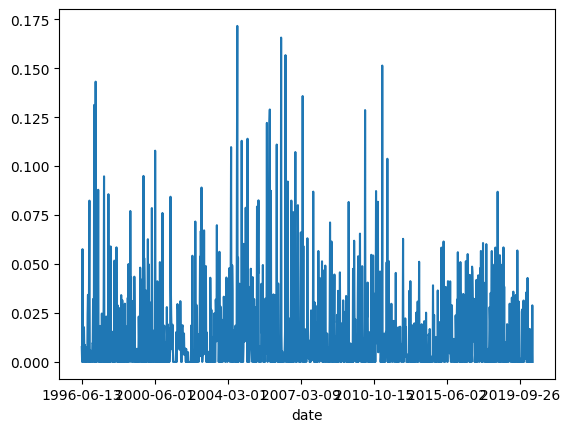

In [142]:
FED_data_roberta_grouped.neg_score.plot()

**30 days Rolling window plot**

In [317]:
FED_data_roberta = pd.read_parquet("FED_data_roberta.parquet")
FED_data_finBERT = pd.read_parquet("FED_data_finbert.parquet")

As OHE speakers are not significant, we remove them 

In [318]:
FED_data_roberta = FED_data_roberta[['neg_score', 'neu_score', 'pos_score', 'agg_score', 'positivness_score',
       'negativness_score', 'neutrality_score', 'spread_score']]
FED_data_finBERT = FED_data_finBERT[['neg_score', 'neu_score', 'pos_score', 'agg_score', 'positivness_score',
       'negativness_score', 'neutrality_score', 'spread_score']]

Compute rolling window for the 2 methods and plot the results
Focus only on negative and positive score to get the polarity 

In [319]:
FED_data_roberta.index = pd.to_datetime(FED_data_roberta.index)
FED_data_finBERT.index = pd.to_datetime(FED_data_finBERT.index)

In [320]:
np.all(FED_data_roberta.index == FED_data_finBERT.index)

True

In [321]:
# Compute hawkishness and forward fill the get the whole serie
FED_data_roberta["hawkishness"] = (FED_data_roberta["neg_score"] / (FED_data_roberta["neg_score"]+FED_data_roberta["pos_score"])).ffill()
FED_data_finBERT["hawkishness"] = (FED_data_finBERT["neg_score"] / (FED_data_finBERT["neg_score"]+FED_data_finBERT["pos_score"])).ffill()

In [322]:
FED_hawkishness_roberta_monthly = FED_data_roberta["hawkishness"].rolling(window="360D").mean().ffill()
FED_hawkishness_finbert_monthly = FED_data_finBERT["hawkishness"].rolling(window="360D").mean().ffill()

#concatenate 
rolling_hawkishness_monthly = pd.concat([FED_hawkishness_roberta_monthly, FED_hawkishness_finbert_monthly], axis=1)
rolling_hawkishness_monthly.columns = ["RoBERTa", "finBERT"]

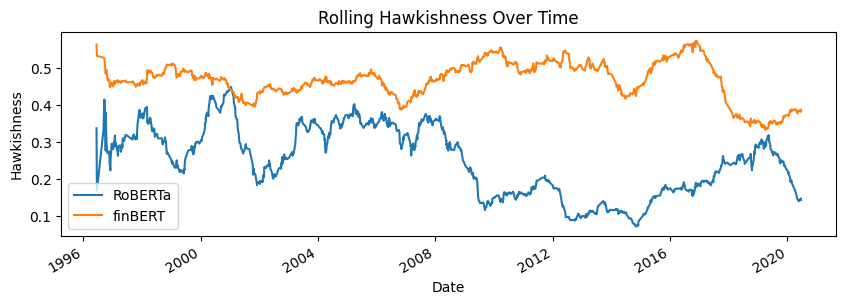

In [323]:
rolling_hawkishness_monthly.plot(figsize=(10,3))
# Customize the plot appearance
plt.xlabel('Date')
plt.ylabel('Hawkishness')
plt.title('Rolling Hawkishness Over Time')
plt.show()

**Regression model**

In [409]:
# show a common date to start
start_date_train = '1998-01-02'
end_date_train = '2018-01-02'
start_date_test = '2018-01-03'
end_date_test = '2020-06-19'

Prepare the data to be input in the automl

In [410]:
FED_data_roberta = FED_data_roberta[["hawkishness", "neg_score", "pos_score"]]
FED_data_roberta["hawkness_3M_mean"] = FED_data_roberta["hawkishness"].rolling(window="90D").mean().ffill()
FED_data_roberta["hawkness_1Y_mean"] = FED_data_roberta["hawkishness"].rolling(window="360D").mean().ffill()
FED_data_roberta["hawkness_2Y_mean"] = FED_data_roberta["hawkishness"].rolling(window="720D").mean().ffill()
FED_data_roberta["hawkness_3M_std"] = FED_data_roberta["hawkishness"].rolling(window="90D").std().ffill()
FED_data_roberta["hawkness_1Y_std"] = FED_data_roberta["hawkishness"].rolling(window="360D").std().ffill()
FED_data_roberta["hawkness_2Y_std"] = FED_data_roberta["hawkishness"].rolling(window="720D").std().ffill()

FED_data_finBERT = FED_data_finBERT[["hawkishness", "neg_score", "pos_score"]]
FED_data_finBERT["hawkness_3M_mean"] = FED_data_finBERT["hawkishness"].rolling(window="90D").mean().ffill()
FED_data_finBERT["hawkness_1Y_mean"] = FED_data_finBERT["hawkishness"].rolling(window="360D").mean().ffill()
FED_data_finBERT["hawkness_2Y_mean"] = FED_data_finBERT["hawkishness"].rolling(window="720D").mean().ffill()
FED_data_finBERT["hawkness_3M_std"] = FED_data_finBERT["hawkishness"].rolling(window="90D").std().ffill()
FED_data_finBERT["hawkness_1Y_std"] = FED_data_finBERT["hawkishness"].rolling(window="360D").std().ffill()
FED_data_finBERT["hawkness_2Y_std"] = FED_data_finBERT["hawkishness"].rolling(window="720D").std().ffill()


Define train/test sets : we will test the 2 models so we need to set the 2 dataframes for each

In [411]:
# Retrieve inversion data
rates_inversions = pd.read_parquet("rates_inversions.parquet")
rates_inversions.index = pd.to_datetime(rates_inversions.index)


# cut dataframe
rates_inversions_train = rates_inversions.loc[start_date_train:end_date_train]
rates_inversions_test = rates_inversions.loc[start_date_test:end_date_test]

roberta_train = FED_data_roberta.loc[start_date_train:end_date_train]
roberta_test = FED_data_roberta.loc[start_date_test:end_date_test]

finbert_train = FED_data_finBERT.loc[start_date_train:end_date_train]
finbert_test = FED_data_finBERT.loc[start_date_test:end_date_test]


# Concatenate roberta with inversions
roberta_inversion_train = pd.concat([rates_inversions_train, roberta_train],axis=1).dropna()
roberta_inversion_test = pd.concat([rates_inversions_test, roberta_test],axis=1).dropna()

# Concatenate finBERT with inversions
finbert_inversion_train = pd.concat([rates_inversions_train, finbert_train],axis=1).dropna()
finbert_inversion_test = pd.concat([rates_inversions_test, finbert_test],axis=1).dropna()


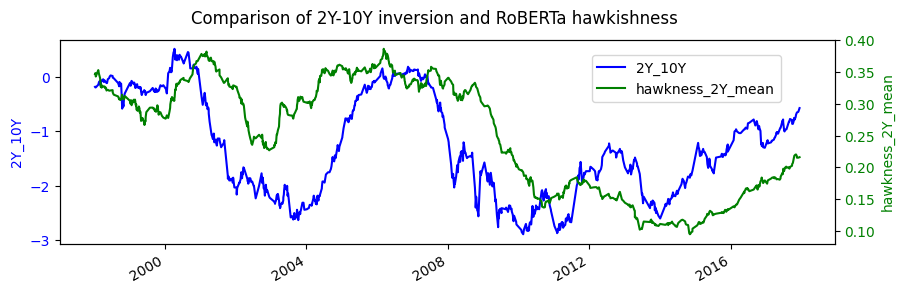

In [412]:
# Plot the two lines with separate y-axes
fig, ax1 = plt.subplots(figsize=(10, 3))

# Plot the first line on the left y-axis
roberta_inversion_train["2Y_10Y"].plot(ax=ax1, color='blue', label='2Y_10Y')
ax1.set_ylabel('2Y_10Y', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the second line
ax2 = ax1.twinx()

# Plot the second line on the right y-axis
roberta_inversion_train["hawkness_2Y_mean"].plot(ax=ax2, color='green', label='hawkness_2Y_mean')
ax2.set_ylabel('hawkness_2Y_mean', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legend and title
fig.suptitle('Comparison of 2Y-10Y inversion and RoBERTa hawkishness')
fig.legend(loc='upper left', bbox_to_anchor=(0.65, 0.85))

# Display the plot
plt.show()

In [413]:
roberta_inversion_train

,3M_2Y,3M_10Y,2Y_10Y,hawkishness,neg_score,pos_score,hawkness_3M_mean,hawkness_1Y_mean,hawkness_2Y_mean,hawkness_3M_std,hawkness_1Y_std,hawkness_2Y_std
1998-01-08,-0.18,-0.36,-0.18,0.443152,0.094761,0.119073,0.463939,0.378221,0.346926,0.376880,0.369867,0.360382
1998-01-12,-0.08,-0.27,-0.19,0.443152,0.000000,0.000000,0.501525,0.373432,0.348453,0.365891,0.373022,0.357670
1998-01-16,-0.20,-0.39,-0.19,0.000000,0.000000,0.005372,0.501525,0.364541,0.343009,0.365891,0.372923,0.357483
1998-02-11,-0.17,-0.31,-0.14,1.000000,0.003396,0.000000,0.468528,0.392583,0.353116,0.330307,0.372495,0.363920
1998-02-17,-0.14,-0.24,-0.10,0.000000,0.000000,0.003611,0.421675,0.392583,0.347766,0.344865,0.372495,0.363717
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-07,-0.41,-1.10,-0.69,0.000000,0.000000,0.000000,0.253568,0.246750,0.220362,0.172253,0.166132,0.165439
2017-11-15,-0.43,-1.08,-0.65,0.000000,0.000000,0.000000,0.236663,0.241776,0.217805,0.178433,0.168601,0.168036
2017-11-16,-0.45,-1.10,-0.65,0.000000,0.000000,0.000000,0.221872,0.241776,0.215358,0.182253,0.168601,0.168666
2017-11-30,-0.51,-1.15,-0.64,0.000000,0.000000,0.023351,0.229148,0.244318,0.215425,0.186229,0.171005,0.170443


In [477]:
def get_X_y(df,y_name):
    X_names = ['hawkness_3M_mean', 'hawkness_1Y_mean', 'hawkness_2Y_mean',
       'hawkness_3M_std', 'hawkness_1Y_std', 'hawkness_2Y_std']
    return df[X_names].pct_change()[1:].ffill(), -np.asarray(df[[y_name]].pct_change().fillna(0)).squeeze()[1:]

def get_X_y_classif(df,y_name):
    X_names = ['hawkness_3M_mean', 'hawkness_1Y_mean', 'hawkness_2Y_mean',
       'hawkness_3M_std', 'hawkness_1Y_std', 'hawkness_2Y_std']
    return df[X_names].pct_change()[1:].ffill(), (-np.asarray(df[[y_name]].pct_change()).squeeze()[1:] >=0)*1

In [482]:
from flaml import AutoML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler

In [471]:
def replace_outliers_with_zero(column):
    q1 = column.quantile(0.15)
    q3 = column.quantile(0.85)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return column.apply(lambda x: 0 if x < lower_bound or x > upper_bound else x)

In [ ]:
all_result = []
all_model = ["RoBERTa","finBERT"]
all_dataset = [[roberta_inversion_train,roberta_inversion_test],
               [finbert_inversion_train,finbert_inversion_test]]
inversion_list = ["3M_2Y","3M_10Y","2Y_10Y"]

for i, dataset in enumerate(all_dataset):
    train_set = dataset[0]
    test_set = dataset[1]
    for inversion in inversion_list:
        X_train, y_train = get_X_y_classif(train_set, inversion)
        X_test, y_test = get_X_y_classif(test_set, inversion)

        X_train = X_train.apply(replace_outliers_with_zero)
        X_test = X_test.apply(replace_outliers_with_zero)

        print(np.sum(np.sum(X_train.isna())))
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Remove labels outliers with IQR
        Q1 = pd.Series(y_train).quantile(0.15)
        Q3 = pd.Series(y_train).quantile(0.85)
        IQR = Q3 - Q1

        # Define upper and lower bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with 0
        y_train[(y_train < lower_bound) | (y_train > upper_bound)] = 0
        y_test[(y_test < lower_bound) | (y_test > upper_bound)] = 0 

        automl = AutoML()
        automl.fit(X_train, y_train, 
                task="classification", 
                metric='accuracy', 
                time_budget=300, 
                eval_method='cv',
                n_splits=3,
                ensemble=True)
        
        # testing on test set 
        y_pred = automl.predict(X_test)

        #mse = mean_squared_error(y_test, y_pred)
        #mae = mean_absolute_error(y_test, y_pred)
        #r2 = r2_score(y_test, y_pred)

        accuracy = accuracy_score(y_test, y_pred)
        
        dict_result = {
            "model":all_model[i],
            "inversion": inversion,
            "best_model": automl.best_estimator,
            "accuracy":accuracy
        }

        all_result.append(dict_result)

In [479]:
import json
# Specify the file path
file_path = 'regression_results.json'

# Save to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(all_result, json_file)

In [480]:
all_result_df = pd.DataFrame(all_result)

In [481]:
all_result_df

,model,inversion,best_model,mse,mae,r2
0,RoBERTa,3M_2Y,xgboost,0.415254,0.415254,-0.760122
1,RoBERTa,3M_10Y,rf,0.406780,0.406780,-0.710145
2,RoBERTa,2Y_10Y,lgbm,0.381356,0.381356,-0.616438
3,finBERT,3M_2Y,xgboost,0.398305,0.398305,-0.688280
4,finBERT,3M_10Y,xgboost,0.440678,0.440678,-0.852657
5,finBERT,2Y_10Y,lgbm,0.372881,0.372881,-0.580518
